In [1]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
from IPython import display
from netCDF4 import Dataset
import datetime as dt
import numpy.ma as ma
from tensorflow.keras import layers

/Users/jhudson/anaconda3/envs/ml_env/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
#Load In the Dataset
# The negative ones give an image shape of 24 x 48 which is easier to work with
ERA5_file = Dataset('/Users/jhudson/Documents/HW/FALL2023/ATS780/ATS780_Homework3/DATA/ERA5_u_v_relVort_200hPa_Colorado.nc')
ERA5_lats = ERA5_file.variables['latitude'][:-1]
ERA5_lons = ERA5_file.variables['longitude'][:-1]
ERA5_time = ERA5_file.variables['time'][:] #hours since 1900-01-01
ERA5_u = ma.getdata(ERA5_file.variables['u'][:,:-1,:-1])
ERA5_v = ma.getdata(ERA5_file.variables['v'][:,:-1,:-1])
ERA5_vort = ma.getdata(ERA5_file.variables['vo'][:,:-1,:-1])
ERA5_dates = np.array([dt.datetime(1900,1,1) + dt.timedelta(hours = int(t)) for t in ERA5_time])

In [ ]:
def calculate_relative_vorticity(u:np.ndarray,v:np.ndarray):

    dv_dx = np.gradient(v,axis = 2)


In [3]:
# now let's normalize the three fields
def normalize_dataset(data:np.ndarray):
    data_min = np.nanmin(data)
    data_max = np.nanmax(data)

    norm_data = (data - data_min) / (data_max - data_min)

    return norm_data

norm_u = normalize_dataset(ERA5_u)
norm_v = normalize_dataset(ERA5_v)
norm_vo = normalize_dataset(ERA5_vort)

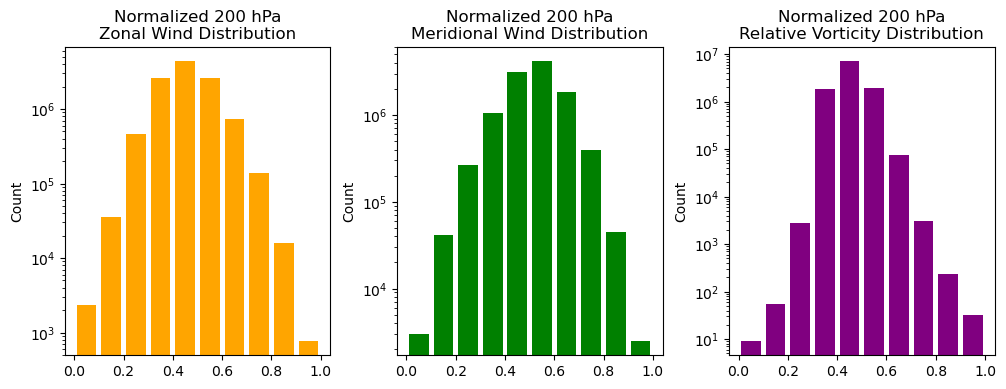

In [4]:
fit, ax = plt.subplots(1,3,figsize = (12,4))

ax[0].hist(norm_u.flatten(),color = 'orange',rwidth = 0.8)
ax[0].set_title("Normalized 200 hPa\nZonal Wind Distribution")
ax[0].set_yscale('log')
ax[0].set_ylabel('Count')

ax[1].hist(norm_v.flatten(),color = 'green',rwidth = 0.8)
ax[1].set_title("Normalized 200 hPa\nMeridional Wind Distribution")
ax[1].set_yscale('log')
ax[1].set_ylabel('Count')

ax[2].hist(norm_vo.flatten(),color = 'purple',rwidth = 0.8)
ax[2].set_title("Normalized 200 hPa\nRelative Vorticity Distribution")
ax[2].set_yscale('log')
ax[2].set_ylabel('Count')

plt.subplots_adjust(wspace = 0.25)

plt.show()

In [5]:
# combine the 3 values together to make a 3 channel 'image'
combined_array = np.empty((len(ERA5_dates),norm_u.shape[1],norm_u.shape[2],3))
combined_array[:,:,:,0] = norm_u[:]
combined_array[:,:,:,1] = norm_v[:]
combined_array[:,:,:,2] = norm_vo[:]
print(combined_array.shape)

(9496, 24, 48, 3)


In [6]:
# Set the Seed and Batch/Shuffle the data
RAND_SEED = 144
BUFFER_SIZE = int(combined_array.shape[0])
BATCH_SIZE = 64
tf.random.set_seed(RAND_SEED)
training_data = tf.data.Dataset.from_tensor_slices(combined_array).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-12-08 11:39:24.740182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


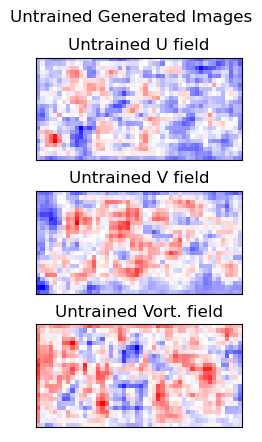

In [7]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(6*12*5, use_bias = False, input_shape = (24*48,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((6,12,5)))
    assert model.output_shape == (None,6,12,5)

    # model.add(layers.Conv2DTranspose(256, (3,3), strides = (1,1), padding = 'same', use_bias = False))
    # assert model.output_shape == (None,3,6,256)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # model.add(layers.UpSampling2D(size = (2,2)))

    model.add(layers.Conv2DTranspose(128, (3,3), strides = (1,1), padding = 'same', use_bias = False))
    assert model.output_shape == (None,6,12,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D(size = (2,2)))

    model.add(layers.Conv2DTranspose(64, (3,3), strides = (1,1), padding = 'same', use_bias = False))
    assert model.output_shape == (None,12,24,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D(size = (2,2)))

    model.add(layers.Conv2DTranspose(32, (3,3), strides = (1,1), padding = 'same', use_bias = False))
    assert model.output_shape == (None,24,48,32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (3,3), strides = (1,1), padding = 'same', use_bias = False))
    assert model.output_shape == (None,24,48,3)

    return model

generator = generator_model()

noise = tf.random.normal([1,24*48])
generated_image = generator(noise, training = False)

fig,ax = plt.subplots(3,1)

ax[0].imshow(generated_image[0,:,:,0],cmap = 'bwr')
ax[0].set_title('Untrained U field')

ax[1].imshow(generated_image[0,:,:,1],cmap = 'bwr')
ax[1].set_title('Untrained V field')

ax[2].imshow(generated_image[0,:,:,2],cmap = 'bwr')
ax[2].set_title('Untrained Vort. field')

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.suptitle('Untrained Generated Images')
plt.subplots_adjust(hspace = 0.3)

plt.show()




In [8]:
def discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(32, (3,3), strides = (1,1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64, (3,3), strides = (1,1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (3,3), strides = (1,1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # model.add(layers.Conv2D(256, (3,3), strides = (1,1), padding = 'same'))
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.15))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision.numpy()[0][0])



-0.0083631


In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)



In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [11]:
noise_dim = 24*48
num_examples_to_generate = 3
seed = tf.random.normal([num_examples_to_generate,noise_dim])

In [12]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [13]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  print(predictions.shape)

  fig,ax = plt.subplots(num_examples_to_generate,3,figsize=(12, 8))

  for i in range(num_examples_to_generate):
    ax[i,0].imshow(predictions[i,:,:,0],cmap = 'bwr')
    ax[i,0].set_title('U-field')
    ax[i,1].imshow(predictions[i,:,:,1],cmap = 'bwr')
    ax[i,1].set_title('V-field')
    ax[i,2].imshow(predictions[i,:,:,2],cmap = 'bwr')
    ax[i,2].set_title('Rel. Vort.-field')

  plt.savefig('/Users/jhudson/Documents/HW/FALL2023/ATS780/ATS780_Homework3/FIGURES/EPOCH_IMS/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

(3, 24, 48, 3)


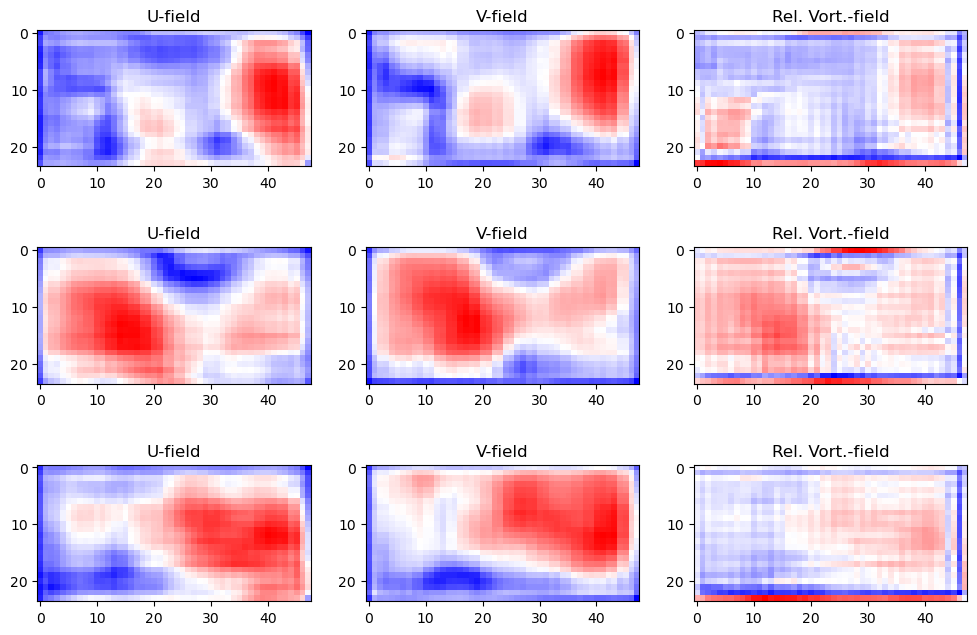

Time for epoch 1 is 118.10866403579712 sec


KeyboardInterrupt: 

In [15]:
EPOCHS = 50
train(training_data, EPOCHS)